In [3]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
(Path.cwd().parent)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/home/ubuntu/varios/skforecast')

In [4]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals
from skforecast.utils import multivariate_time_series_corr
from skforecast.plot import plot_multivariate_time_series_corr
from skforecast.plot import plot_prediction_distribution

# Plot Residuals

In [5]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

In [6]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = False
                               )

In [7]:
residuals = predictions_backtest['pred'] - data_test['y']

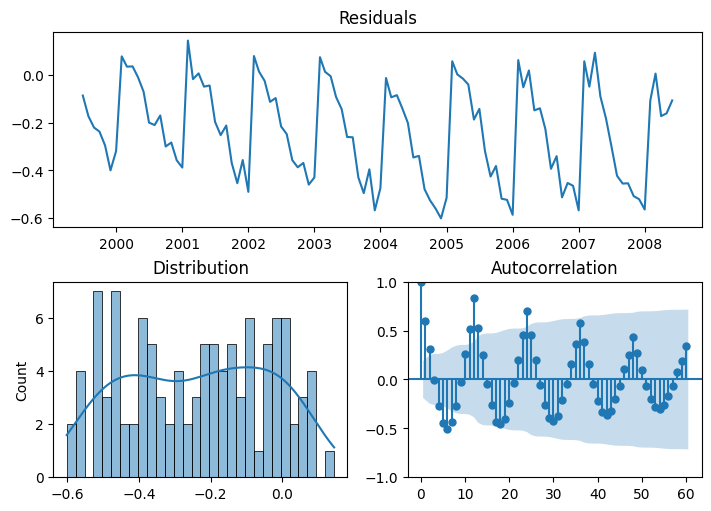

In [8]:
fig  = plot_residuals(residuals=residuals, figsize=(7, 5))

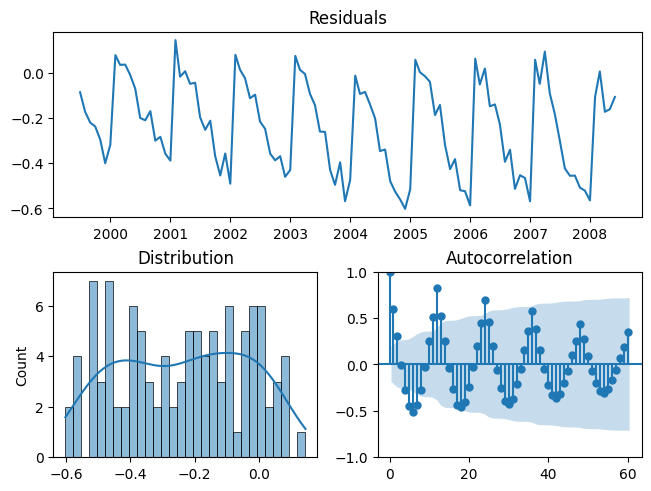

In [9]:
fig  = plot_residuals(y_true=data_test['y'], y_pred=predictions_backtest['pred'])

# multivariate_time_series_corr 

In [10]:
# Data download
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
    'Estadistica-machine-learning-python/master/data/air_quality_valencia.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.drop(columns=['veloc.', 'direc.'])
data = data.asfreq('H')
data = data.sort_index()
data = data.loc['2021-01-01 00:00:00': '2021-12-31 11:00:00']

# Aggregating in 1D intervals
# ==============================================================================
data = data.resample(rule='D', closed='left', label ='left').mean()
data.head()

# Missing imputation with rolling mean
# ==============================================================================
data['pm2.5'] = data['pm2.5'].fillna(data['pm2.5'].rolling(window='25d', center=True, axis=0).mean())
data['pm10']  = data['pm10'].fillna(data['pm10'].rolling(window='25d', center=True, axis=0).mean())
data['co']    = data['co'].fillna(data['co'].rolling(window='10d', center=True, axis=0).mean())
data['o3']    = data['o3'].fillna(data['o3'].rolling(window='5d', center=True, axis=0).mean())
data['so2']   = data['so2'].fillna(data['so2'].rolling(window='10d', center=True, axis=0).mean())

data= pd.concat([data,data,data,data,data])

In [11]:
corr = multivariate_time_series_corr(
    time_series = data['pm2.5'],
    other       = data,
    lags        = 5
)
corr

,pm2.5,co,no,no2,pm10,nox,o3,so2
lag,,,,,,,,
0,1.000000,-0.050437,0.358713,0.427705,0.835836,0.435800,-0.260211,-0.123025
1,0.774216,-0.099094,0.228872,0.386544,0.696288,0.350768,-0.203467,-0.131022
2,0.541201,-0.076636,0.171215,0.283146,0.548634,0.259532,-0.181258,-0.126705
3,0.385159,-0.049723,0.063409,0.121179,0.429336,0.108291,-0.105378,-0.123055
4,0.305035,-0.036743,0.009427,0.012708,0.357420,0.014990,-0.043324,-0.121805


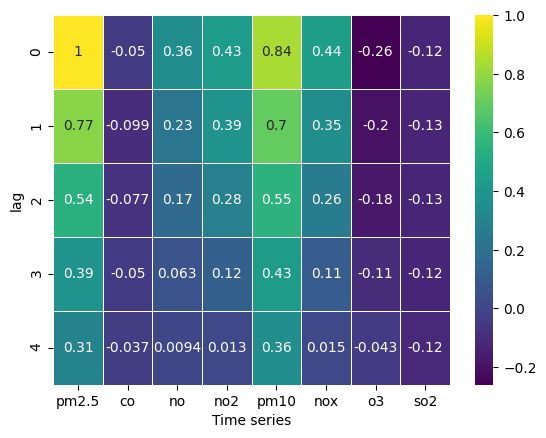

In [12]:
fig = plot_multivariate_time_series_corr(corr)

# Ridge Plot

In [13]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

In [34]:
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 12 
             )
forecaster.fit(y=data.y)
pred = forecaster.predict_bootstrapping(steps=7)
pred

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_490,pred_boot_491,pred_boot_492,pred_boot_493,pred_boot_494,pred_boot_495,pred_boot_496,pred_boot_497,pred_boot_498,pred_boot_499
2008-07-01,0.866128,0.889717,0.929460,0.941787,0.974730,0.866572,0.949614,1.032005,1.011213,0.885619,...,0.815416,0.954116,0.853692,0.957895,0.968973,1.057918,0.974490,0.977663,0.981682,0.899364
2008-08-01,0.960084,0.872745,1.023084,1.057309,1.085943,1.103582,0.964053,1.070189,1.085515,0.954916,...,1.041452,1.059069,1.079620,1.069621,1.146014,1.074593,0.988948,0.977274,1.061225,0.977778
2008-09-01,1.229110,1.085125,0.981162,1.128296,1.187328,1.115549,1.003167,1.004431,1.171342,0.990184,...,1.054573,1.047886,1.014685,1.262861,1.123702,1.022284,1.119543,1.036933,1.099997,1.159431
2008-10-01,1.111807,1.154682,1.113333,1.174623,1.202458,1.117738,1.145275,1.215068,1.050079,1.195999,...,1.119017,1.182474,1.154212,1.200204,1.203532,1.083780,1.187659,1.183170,1.237327,1.344571
2008-11-01,1.201595,1.202587,1.085440,1.224644,1.129489,1.148538,1.101443,1.165078,1.094016,1.049580,...,1.169903,1.209337,1.161360,1.172574,1.243763,1.095002,1.155554,1.376257,1.229542,1.245798
2008-12-01,1.205671,1.210063,1.126968,1.217419,1.103715,1.146791,1.267936,1.107083,1.198423,1.193248,...,1.161858,1.155185,1.118852,1.094321,1.119469,1.198664,1.253101,1.244128,1.159731,1.263436
2009-01-01,1.122412,1.298071,1.020161,1.054169,1.113503,1.018864,1.242227,1.230791,1.206366,1.211504,...,1.185571,1.231038,1.171003,1.091306,1.303903,1.012086,1.096543,1.044768,1.125608,1.044309


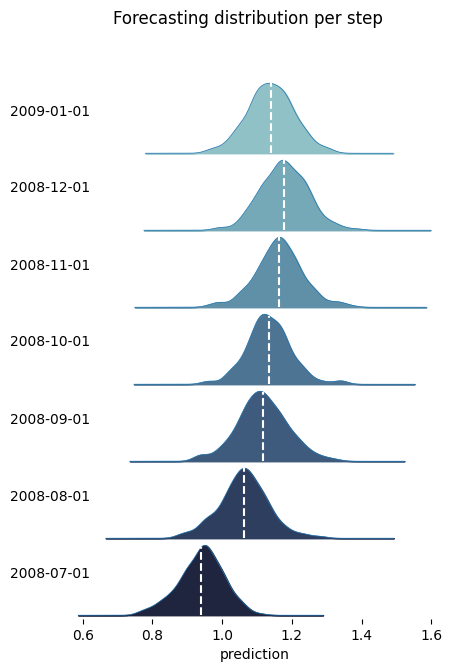

In [35]:
fig = plot_prediction_distribution(pred, bw_method=None, figsize=(5, 7))

In [16]:
# def plot_prediction_distributions(bootstrapping_predictions):
#     """
    

#     Parameters
#     ----------
#     bootstrapping_predictions : pandas DataFrame
#         _description_
#     """

#     df = bootstrapping_predictions.stack().droplevel(level=1, axis=0).to_frame(name='pred')
#     df.index.name='step'
#     df = df.reset_index()
#     df['step'] = df['step'].astype(str)
#     df

#     sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
#     palette = sns.cubehelix_palette(10, rot=-.25, light=.7, reverse=True)
#     row_order = list(df.step.unique())
#     row_order.reverse()
#     g = sns.FacetGrid(df, palette=palette, row="step", hue="step", aspect=20, height=0.8, row_order=row_order)
#     g.map_dataframe(sns.kdeplot, x="pred", fill=True, alpha=1)
#     g.map_dataframe(sns.kdeplot, x="pred", color='w', lw=2)
#     def label(x, color, label):
#         ax = plt.gca()
#         ax.text(0, .2, label, color='black', fontsize=13,
#                 ha="left", va="center", transform=ax.transAxes)
        
#     g.map(label, "step")
#     g.fig.subplots_adjust(hspace=-.5)
#     g.set_titles("")
#     g.set(yticks=[], xlabel="pred")
#     g.despine(left=True)
#     plt.suptitle('Prediction distribution', y=0.98)
    
#     return g


# plot = plot_prediction_distributions(pred)